# PANDAS EXPLODE FUNCTION

In [20]:
# Importing Libraries
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt  
import ast

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
# this badboy right down here is added to turn values of "job_skills" column into list type 
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

1. Why is df.explode() needed?

- Import a fake dataset of 3 job postings:

In [3]:
data = {
    'job_title_short': ['Data Analyst', 'Data Scientist', 'Data Engineer'],
    'job_skills': [['excel', 'sql', 'python'], ['python', 'r'], ['aws', 'python', 'airflow']]
}

df_skills = pd.DataFrame(data)

df_skills

,job_title_short,job_skills
0,Data Analyst,"[excel, sql, python]"
1,Data Scientist,"[python, r]"
2,Data Engineer,"[aws, python, airflow]"


- It conventionally takes 5 line of code to get the counts of skills

In [12]:
df_skills_list = df_skills.copy()

for row in df_skills_list.itertuples(): # each row become a tuple
    for skill in row.job_skills: # row.job_skills used to access an item which is a list of skills in each tuple
        df_skills_list[skill] = df_skills_list['job_skills'].apply(lambda x: skill in x) # if the skill is in the list, return True
        df_skills_list[skill] = df_skills_list[skill].astype(int) # convert True to 1, False to 0

df_skills_list.loc['Total'] = df_skills_list.sum()

df_skills_list.iloc[:,2:] # 1sr arg is the row, 2nd arg is the column


,excel,sql,python,r,aws,airflow
0,1,1,1,0,0,0
1,0,0,1,1,0,0
2,0,0,1,0,1,1
Total,1,1,3,1,1,1


- Then God brings us Explode function

In [22]:
df_explode = df_skills.explode('job_skills').copy()

df_explode_agg = df_explode.value_counts('job_skills') # now that we can use value counts
df_explode_agg

job_skills
python     3
airflow    1
aws        1
excel      1
r          1
sql        1
Name: count, dtype: int64

<Axes: xlabel='job_skills'>

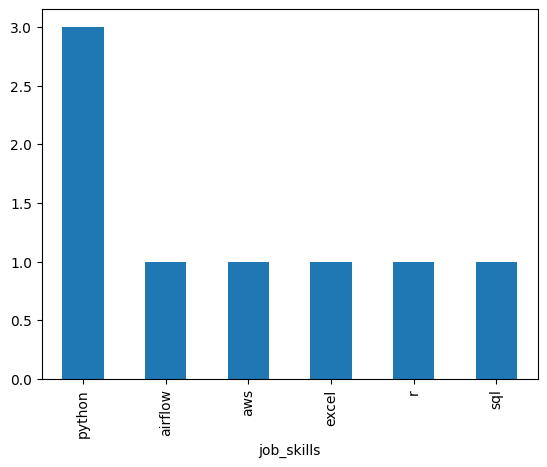

In [19]:

df_explode_agg.plot(kind='bar') # create a column chart with this babyboo

2. So, what is the explode function?

In [21]:
help(df.explode)

Help on method explode in module pandas.core.frame:

explode(column: 'IndexLabel', ignore_index: 'bool' = False) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Transform each element of a list-like to a row, replicating index values.
    
    Parameters
    ----------
    column : IndexLabel
        Column(s) to explode.
        For multiple columns, specify a non-empty list with each element
        be str or tuple, and all specified columns their list-like data
        on same row of the frame must have matching length.
    
        .. versionadded:: 1.3.0
            Multi-column explode
    
    ignore_index : bool, default False
        If True, the resulting index will be labeled 0, 1, …, n - 1.
    
    Returns
    -------
    DataFrame
        Exploded lists to rows of the subset columns;
        index will be duplicated for these rows.
    
    Raises
    ------
    ValueError :
        * If columns of the frame are not unique.
        * If specified columns

--> Transform each element of the "job_skills" list to a row, the row index will be duplicated because now each element exploded and become a separate row now that the table has more rows than before

- Let's try this badboy function on "job_skills" column of the df DataFrame

In [24]:
df_explode2 = df.explode(['job_skills'])
df_explode2.value_counts("job_skills")

job_skills
sql             384849
python          380909
aws             145381
azure           132527
r               130892
                 ...  
dingtalk             1
rocketchat           1
rubyon rails         1
wimi                 1
msaccess             1
Name: count, Length: 252, dtype: int64

- Filter top 10 and create a chart babyyy

<Axes: ylabel='job_skills'>

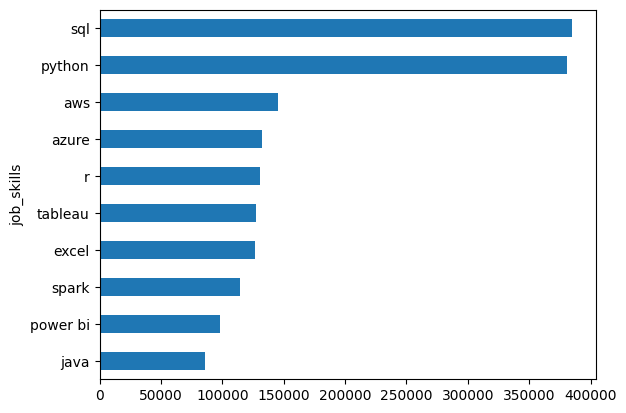

In [28]:
df_explode_agg2 = df_explode2.value_counts("job_skills").head(10).sort_values(ascending= True)
df_explode_agg2.plot(kind="barh")

3. Group the data by job titles and exploded job skills

In [33]:
skills_count = df_explode2.groupby(['job_title_short','job_skills']).size()

type(skills_count)

pandas.core.series.Series

-> we want to work with DataFrame instead of Series so we have to change it to DataFrame

In [45]:
df_skills_count = skills_count.reset_index() # all you need to do is reset index??

type(df_skills_count)

pandas.core.frame.DataFrame

In [46]:
df_skills_count

,job_title_short,job_skills,0
0,Business Analyst,airflow,318
1,Business Analyst,airtable,17
2,Business Analyst,alteryx,1078
3,Business Analyst,angular,87
4,Business Analyst,ansible,120
...,...,...,...
2251,Software Engineer,wrike,4
2252,Software Engineer,wsl,13
2253,Software Engineer,xamarin,35
2254,Software Engineer,yarn,145


-> Voila, it has become a DataFrame, but the count colum has no name

In [47]:
df_skills_count = skills_count.reset_index(name='skills_count') 

df_skills_count = df_skills_count.sort_values(by = 'skills_count',ascending=False)

df_skills_count

,job_title_short,job_skills,skills_count
1066,Data Scientist,python,113711
865,Data Engineer,sql,113130
830,Data Engineer,python,108022
625,Data Analyst,sql,92428
1101,Data Scientist,sql,78982
...,...,...,...
266,Cloud Engineer,delphi,1
1920,Senior Data Scientist,objective-c,1
1400,Senior Data Analyst,couchdb,1
298,Cloud Engineer,haskell,1


4. Find the top 10 skills required for a DA position

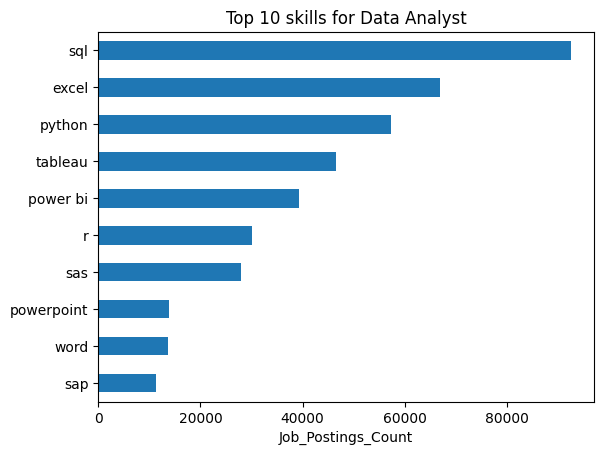

In [85]:
job_title = 'Data Analyst'
top_skills = 10

df_skill_final = df_skills_count[df_skills_count['job_title_short']== job_title].sort_values( by= 'skills_count', ascending= False).head(top_skills)

df_skill_final.plot(kind='barh',y='skills_count',x ='job_skills')
plt.gca().invert_yaxis() 
# -> gca used to get the current axes because invert_yaxis run on Axes instead of Dataframe
# -> we can use this method instead of using sort_values function
plt.title(f'Top {top_skills} skills for {job_title}') # this is the cherry on top
plt.xlabel('Job_Postings_Count')
plt.ylabel('')
plt.legend().set_visible(False) # when you wanna hide the legend, use this to find me 3 months later Toan

-> Now we can filter the chart by job title or number of top skills, how convenient 